In [1]:
# import transformers
from datasets import load_dataset
from transformers import AutoModelForQuestionAnswering, BertModel, BertConfig, BertTokenizer, pipeline, AutoTokenizer
from tqdm import tqdm
import torch
import torch.nn as nn



dataset = load_dataset("squad")
train = dataset['train']
validation = dataset['validation']

question_answerer = pipeline("question-answering", model='AliHashish/distilbert-base-uncased-finetuned-squad-EZcufe')
model_checkpoint = "atharvamundada99/bert-large-question-answering-finetuned-legal"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
pretrained_model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Found cached dataset parquet (C:/Users/DELL/.cache/huggingface/datasets/parquet/plain_text-57edf78d6033ac9a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
# total = 0
# correct = 0
# errors = []
# for record in tqdm(validation):
#         try:
#                 total += 1
#                 if (total % 1000 == 0):
#                         print(f"Accuracy: {100*correct/total}")
#                         print(f"Correct: {correct}, out of {total}")
#                 result = question_answerer(question=record['question'], context=record['context'], truncation=True, padding=True, return_tensors='pt')
#                 if result['answer'].lower() in record['answers']['text'][0].lower() or record['answers']['text'][0].lower() in result['answer'].lower():
#                         correct += 1
#         except Exception as e:
#                 errors.append(total)
#                 print(f"Error at {total}: {e}")
#                 continue
# print("Accuracy: ", 100 * correct / total)

In [3]:
# # dh 3lshan ykamel fl iteration lw w2fna fl nos

# print(f"Accuracy: {100*correct/total}")
# print(f"Correct: {correct}, out of {total}")
# print(f"Errors: {errors}")
# prev_total = total
# total = 0
# for record in tqdm(validation):
#         try:
#                 total += 1
#                 if total < prev_total:
#                         continue
#                 if (total % 1000 == 0):
#                         print(f"Accuracy: {100*correct/total}")
#                         print(f"Correct: {correct}, out of {total}")
#                 result = question_answerer(question=record['question'], context=record['context'], truncation=True, padding=True, return_tensors='pt')
#                 if result['answer'].lower() in record['answers']['text'][0].lower() or record['answers']['text'][0].lower() in result['answer'].lower():
#                         correct += 1
#         except Exception as e:
#                 errors.append(total)
#                 print(f"Error at {total}: {e}")
#                 continue

# print(f"Accuracy: {100*correct/total}")
# print(f"Correct: {correct}, out of {total}")

In [4]:
# # get model architecture
# print("model.config: ", pretrained_model.config)
# print("============================================================================================")

# # get model parameters
# print("model.parameters: ", pretrained_model.parameters)
# print("============================================================================================")

# # get model layers
# print("model.layers: ", pretrained_model.bert.encoder.layer)
# print("============================================================================================")

# # get model weights
# print("model.weights: ", pretrained_model.state_dict())
# print("============================================================================================")

# print("model.layers: ", len(pretrained_model.bert.encoder.layer))



In [5]:
# model.parameters:  <bound method Module.parameters of BertForQuestionAnswering(
#   (bert): BertModel(
#     (embeddings): BertEmbeddings(
#       (word_embeddings): Embedding(30522, 1024, padding_idx=0)
#       (position_embeddings): Embedding(512, 1024)
#       (token_type_embeddings): Embedding(2, 1024)
#       (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
#       (dropout): Dropout(p=0.1, inplace=False)
#     )
#     (encoder): BertEncoder(
#       (layer): ModuleList(
#         (0-23): 24 x BertLayer(
#           (attention): BertAttention(
#             (self): BertSelfAttention(
#               (query): Linear(in_features=1024, out_features=1024, bias=True)
#               (key): Linear(in_features=1024, out_features=1024, bias=True)
#               (value): Linear(in_features=1024, out_features=1024, bias=True)
#               (dropout): Dropout(p=0.1, inplace=False)
#             )
#             (output): BertSelfOutput(
#               (dense): Linear(in_features=1024, out_features=1024, bias=True)
#               (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
#               (dropout): Dropout(p=0.1, inplace=False)
#             )
#           )
#           (intermediate): BertIntermediate(
#             (dense): Linear(in_features=1024, out_features=4096, bias=True)
#             (intermediate_act_fn): GELUActivation()
#           )
#           (output): BertOutput(
#             (dense): Linear(in_features=4096, out_features=1024, bias=True)
#             (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
#             (dropout): Dropout(p=0.1, inplace=False)
#           )
#         )
#       )
#     )
#   )
#   (qa_outputs): Linear(in_features=1024, out_features=2, bias=True)
# )>

In [6]:
class CustomBertForQuestionAnswering(nn.Module):
    def __init__(self, config):
        super(CustomBertForQuestionAnswering, self).__init__()
        self.bert = BertModel(config)
        self.qa_outputs = nn.Linear(config.hidden_size, 2)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs.last_hidden_state
        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
        return start_logits, end_logits

# Instantiate the model with the provided configuration
config = BertConfig.from_dict({
    "_name_or_path": "ourModel",
    "architectures": [
        "BertForQuestionAnswering"
    ],
    "attention_probs_dropout_prob": 0.1,
    "gradient_checkpointing": False,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 1024,
    "initializer_range": 0.02,
    "intermediate_size": 4096,
    "layer_norm_eps": 1e-12,
    "max_position_embeddings": 512,
    "model_type": "bert",
    "num_attention_heads": 16,
    "num_hidden_layers": 24,
    "pad_token_id": 0,
    "position_embedding_type": "absolute",
    "transformers_version": "4.17.0",
    "type_vocab_size": 2,
    "use_cache": True,
    "vocab_size": 30522
})

model = CustomBertForQuestionAnswering(config)


In [7]:
# Get state dictionary of pre-trained model
pretrained_dict = pretrained_model.state_dict()

# Get state dictionary of custom model
model_dict = model.state_dict()

print(len(pretrained_dict))

# Filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print(len(pretrained_dict))

# Overwrite entries in the existing state dict
model_dict.update(pretrained_dict)

# Load the new state dict
model.load_state_dict(model_dict)

392
392


<All keys matched successfully>

In [8]:
# model.eval()

CustomBertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024

In [9]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


In [13]:
def QA(model, tokenizer, question, context):
    # Process the inputs
    inputs = tokenizer(question, context, return_tensors='pt')

    # Pass the inputs through the model and get the start and end scores
    start_scores, end_scores = model(**inputs)

    # Get the start and end positions
    start_position = torch.argmax(start_scores)
    end_position = torch.argmax(end_scores)

    # Get the answer
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][start_position:end_position+1]))

    return answer

def QAs(model, tokenizer, questions, contexts):
    answers = []
    for question, context in zip(questions, contexts):
        answer = QA(model, tokenizer, question, context)
        answers.append(answer)
    return answers

def Evaluation(model, tokenizer, validation):
    correct = 0
    EM = 0
    total = 0
    errors = []
    for record in tqdm(validation):
        try:
            total += 1
            if (total % 500 == 0):
                print(f"\nAccuracy: {100*correct/total}")
                print(f"Correct: {correct}, out of {total}")
                print(f"EM: {100*EM/total}")
                print(f"EM Correct: {EM}, out of {total}\n")

            predicted_answer = QA(model, tokenizer, record['question'], record['context'])
            if predicted_answer.lower() in record['answers']['text'][0].lower() or record['answers']['text'][0].lower() in predicted_answer.lower():
                correct += 1
            if predicted_answer.lower() == record['answers']['text'][0].lower():
                EM += 1
        except Exception as e:
            errors.append(total)
            print(f"Error at {total}: {e} ")
            continue
    return correct, EM, total

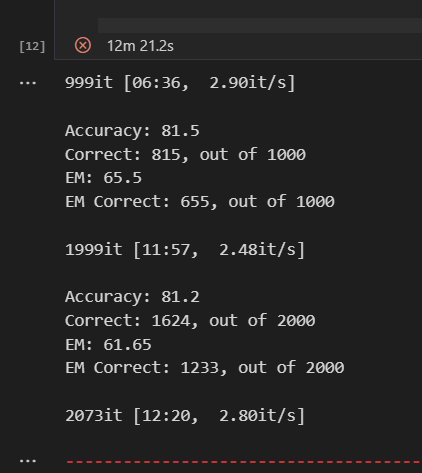

In [14]:
correct, EM, total = Evaluation(pretrained_model, tokenizer, validation)


  9%|▉         | 999/10570 [11:07<1:53:44,  1.40it/s]


Accuracy: 84.3
Correct: 843, out of 1000
EM: 68.0
EM Correct: 680, out of 1000



 19%|█▉        | 1999/10570 [19:06<55:49,  2.56it/s]  


Accuracy: 83.45
Correct: 1669, out of 2000
EM: 63.5
EM Correct: 1270, out of 2000



 22%|██▏       | 2308/10570 [20:59<1:15:09,  1.83it/s]


KeyboardInterrupt: 

In [16]:
print(pretrained_model.training)

<bound method Module.eval of BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (Laye